# Predicting the startup valuation amount in USD

In this notebook, we will create different machine learning models to predict the total funding in USD for a startup. All models will be tested using 5-fold cross-validation and the best model will be chosen at the end.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

First, let's import the dataset from Q1:

In [2]:
data_ = pd.read_pickle("../data/df_merged_kaggle_LY_market.pkl")
data_

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000.0,operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/club-domains,.Club Domains,http://nic.club/,|Software|,Software,7000000.0,NaN,USA,FL,Ft. Lauderdale,...,0.0,0.0,0.0,7000000.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28724,/organization/zyraz-technology,Zyraz Technology,http://www.zyraz.com,|Biotechnology|,Biotechnology,15419877.0,closed,MYS,NaN,MYS - Other,...,0.0,0.0,7991547.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28725,/organization/zytoprotec,Zytoprotec,http://www.zytoprotec.com,|Biotechnology|,Biotechnology,2686600.0,operating,AUT,NaN,Vienna,...,0.0,0.0,2686600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28726,/organization/zzish,Zzish,http://www.zzish.com,|Analytics|Gamification|Developer APIs|iOS|And...,Education,320000.0,operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28727,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,|Web Development|Advertising|Wireless|Mobile|,Web Development,97398.0,operating,HRV,NaN,Split,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will drop some irrelevant columns from the dataset that won't be used for the prediction.

In [3]:
# first let's drop some irrelevant columns, like name, permalink, homepage_url
data_.drop(columns = ['permalink', 'name', 'homepage_url', 'category_list_formatted', 'category_list'], inplace = True)
# remove precise dates as they will be covered by the Year column, continent will be dropped because its resolution is very low
data_.drop(columns = ['first_funding_at', 'last_funding_at', 'founded_at', 'continent'], inplace = True)
data_

,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_YEAR,first_funding_YEAR,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Publishing,40000.0,operating,EST,NaN,Tallinn,Tallinn,1,2012,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Electronics,1500000.0,operating,GBR,NaN,London,London,1,2011,2011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Tourism,60000.0,operating,USA,TX,Dallas,Fort Worth,2,2014,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Software,7000000.0,NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,2011,2013,...,0.0,0.0,0.0,7000000.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28724,Biotechnology,15419877.0,closed,MYS,NaN,MYS - Other,Damansara New Village,4,1994,2008,...,0.0,0.0,7991547.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28725,Biotechnology,2686600.0,operating,AUT,NaN,Vienna,Gerasdorf Bei Wien,1,2007,2013,...,0.0,0.0,2686600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28726,Education,320000.0,operating,GBR,NaN,London,London,1,2013,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28727,Web Development,97398.0,operating,HRV,NaN,Split,Split,5,2012,2011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, let's explore the 'quality' of the data a little bit.. How much missing data do we have per column?

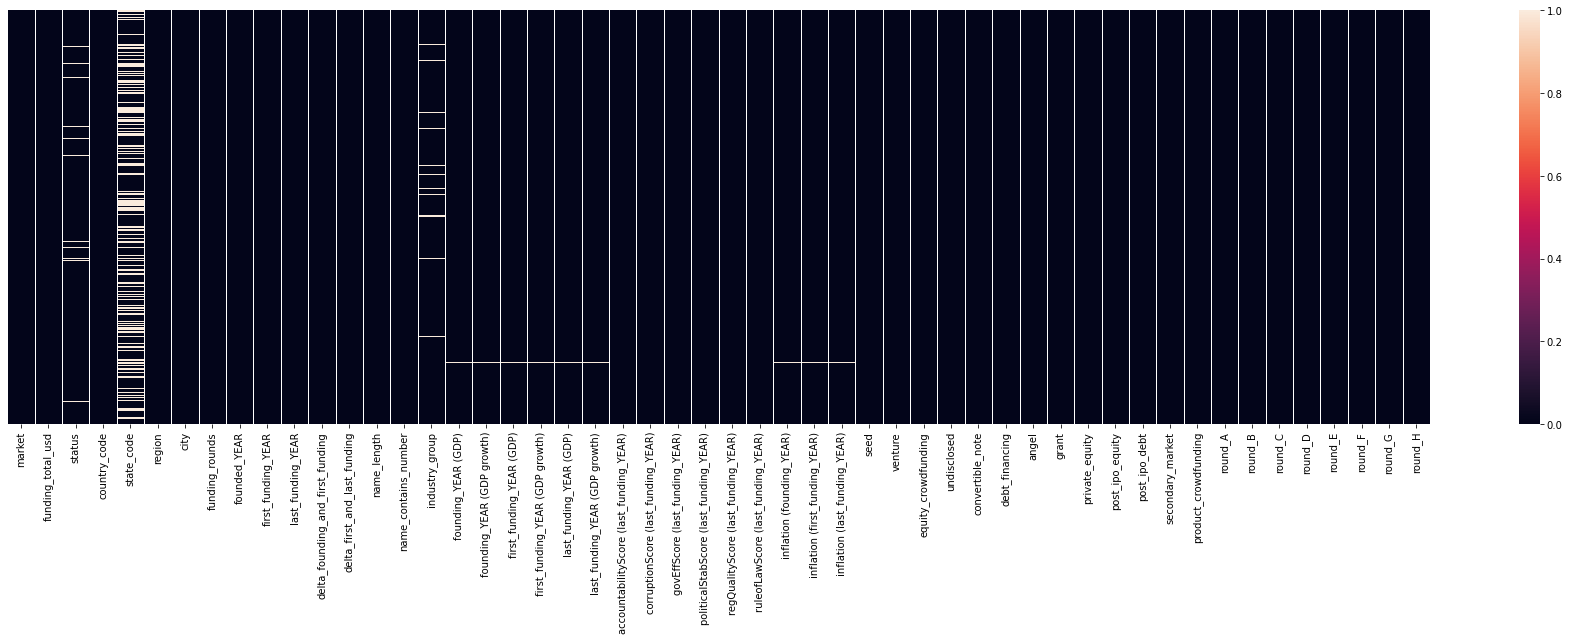

In [4]:
fig, ax = plt.subplots(figsize=(25,9))
sns.heatmap(data = data_.isna(),
            yticklabels=False,
            ax = ax )
for i in range(data_.shape[1]+1):
    ax.axvline(i, color='white', lw=1)
plt.tight_layout()
plt.show()

In [5]:
data_.isna().sum()

market                                        0
funding_total_usd                             0
status                                      644
country_code                                  0
state_code                                 8415
region                                        0
city                                          0
funding_rounds                                0
founded_YEAR                                  0
first_funding_YEAR                            0
last_funding_YEAR                             0
delta_founding_and_first_funding              0
delta_first_and_last_funding                  0
name_length                                   0
name_contains_number                          0
industry_group                              833
founding_YEAR (GDP)                           9
founding_YEAR (GDP growth)                    9
first_funding_YEAR (GDP)                      9
first_funding_YEAR (GDP growth)               9
last_funding_YEAR (GDP)                 

It seems that especially the columns state_code, status, and industry_group have a lot of missing values. There are also a few missing values for the political indicators and GDP

In [6]:
# because the state_code only applies to the US, it will be dropped. Comparable information is contained in the region and/or city column.
data_.drop(columns='state_code', inplace = True)

In [7]:
# the number of affected rows with missing values for founded_YEAR (GDP) and accountability score is very small.
# We will also delete those rows because the make up a neglible percentage of our dataset. Also, they seem to refer to the same observations.
data_ = data_[data_['founding_YEAR (GDP)'].notna()]
data_ = data_[data_['accountabilityScore (last_funding_YEAR)'].notna()]
data_ = data_[data_['inflation (founding_YEAR)'].notna()]

In [9]:
# the two columns with the most missing values are status and industry group with 644 and 832 missing observations, respectively.
df_missing_status = data_[data_['status'].isna()]
df_notMissing_status =data_[data_['status'].notna()]

x_missing_status_funding = df_missing_status['funding_total_usd']
x_notMissing_status_funding = df_notMissing_status['funding_total_usd']

In [10]:
x_missing_status_funding.describe()

count    6.440000e+02
mean     1.243716e+07
std      3.774389e+07
min      2.150000e+02
25%      3.237500e+05
50%      2.000000e+06
75%      9.375614e+06
max      5.000000e+08
Name: funding_total_usd, dtype: float64

In [11]:
x_notMissing_status_funding.describe()

count    2.803500e+04
mean     1.580517e+07
std      7.729287e+07
min      1.400000e+01
25%      4.000000e+05
50%      2.100000e+06
75%      1.030000e+07
max      5.700000e+09
Name: funding_total_usd, dtype: float64

In [12]:
## maybe add a overlayed histogram to show whether the two values are different
# given their mean and standard devaition, however, they do not appear to differ significantly
data_ = data_[data_['status'].notna()]

In [13]:
# let's look at the industry group now.
df_missing_industryGroup = data_[data_['industry_group'].isna()]
df_notMissing_industryGroup = data_[data_['industry_group'].notna()]

x_missing_industryGroup_funding = df_missing_industryGroup['funding_total_usd']
x_notMissing_industryGroup_funding = df_notMissing_industryGroup['funding_total_usd']

In [14]:
x_missing_industryGroup_funding.describe()

count    7.430000e+02
mean     1.383181e+07
std      1.917612e+08
min      1.400000e+01
25%      1.000000e+05
50%      5.000000e+05
75%      3.012163e+06
max      5.162513e+09
Name: funding_total_usd, dtype: float64

In [15]:
x_notMissing_industryGroup_funding.describe()

count    2.729200e+04
mean     1.585890e+07
std      7.167247e+07
min      3.000000e+01
25%      4.350000e+05
50%      2.200000e+06
75%      1.060000e+07
max      5.700000e+09
Name: funding_total_usd, dtype: float64

In [16]:
# agian, the two groups fo not appear to differ significantly
data_ = data_[data_['industry_group'].notna()]

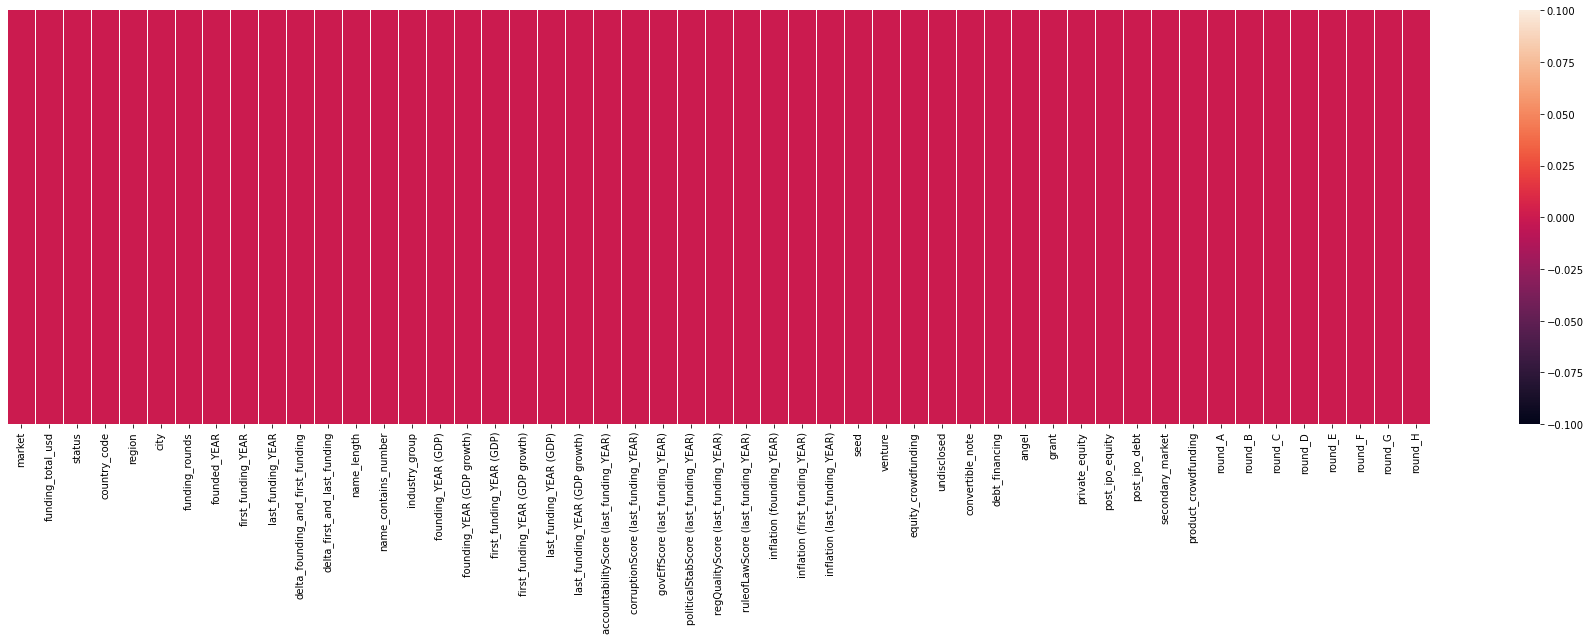

In [17]:
fig, ax = plt.subplots(figsize=(25,9))
sns.heatmap(data = data_.isna(),
            yticklabels=False,
            ax = ax )
for i in range(data_.shape[1]+1):
    ax.axvline(i, color='white', lw=1)
plt.tight_layout()
plt.show()

No missing data anymore.. Initially there were 28729 observations in the dataset. After removing observations with missing values, the dataset consists of 27292 observations. So, we lost ~8 % of our dataset which appears to be a fair compromise.

In [18]:
# the delta columns will be converted to integers as well so they show the number of days
data_['delta_founding_and_first_funding'] = data_['delta_founding_and_first_funding'].dt.days
data_['delta_first_and_last_funding'] = data_['delta_first_and_last_funding'].dt.days

In [19]:
data_

,market,funding_total_usd,status,country_code,region,city,funding_rounds,founded_YEAR,first_funding_YEAR,last_funding_YEAR,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,News,1750000.0,acquired,USA,New York City,New York,1,2012,2012,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Publishing,40000.0,operating,EST,Tallinn,Tallinn,1,2012,2012,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Electronics,1500000.0,operating,GBR,London,London,1,2011,2011,2011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Tourism,60000.0,operating,USA,Dallas,Fort Worth,2,2014,2014,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,E-Commerce,40000.0,operating,CHL,Santiago,Las Condes,1,2012,2013,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28724,Biotechnology,15419877.0,closed,MYS,MYS - Other,Damansara New Village,4,1994,2008,2013,...,0.0,0.0,7991547.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28725,Biotechnology,2686600.0,operating,AUT,Vienna,Gerasdorf Bei Wien,1,2007,2013,2013,...,0.0,0.0,2686600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28726,Education,320000.0,operating,GBR,London,London,1,2013,2014,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28727,Web Development,97398.0,operating,HRV,Split,Split,5,2012,2011,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### One Hot Encoding

As there are some columns with categorical data in our dataset, we have to convert them to numeric data so that machine learning model can use it. We will use one-hot encoding because label encoding is usually used for ordinal or 'rankable' data. Given that none of the categories of the categorical columns can be ranked, one hot encoding is suitable and preferred over label encoding. To create an exhaustive column set, we will drop the first column.

In [20]:
# first let's copy the dataframe and remove all categorical columns which could be substituted by oneHot codes
data_train = data_.copy(deep = True)

In [21]:
# we won't use city as a predictor, as it is too specific, instead, we will use region as it is less granular as city, but more granual then country. This would also allow us to distinguish between different regions in a country (e.g Silicon Valley vs New York)
#data_train.drop(columns = ['market', 'status', 'country_code', 'region', 'city', 'industry_group'], inplace = True)
data_train

,market,funding_total_usd,status,country_code,region,city,funding_rounds,founded_YEAR,first_funding_YEAR,last_funding_YEAR,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,News,1750000.0,acquired,USA,New York City,New York,1,2012,2012,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Publishing,40000.0,operating,EST,Tallinn,Tallinn,1,2012,2012,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Electronics,1500000.0,operating,GBR,London,London,1,2011,2011,2011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Tourism,60000.0,operating,USA,Dallas,Fort Worth,2,2014,2014,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,E-Commerce,40000.0,operating,CHL,Santiago,Las Condes,1,2012,2013,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28724,Biotechnology,15419877.0,closed,MYS,MYS - Other,Damansara New Village,4,1994,2008,2013,...,0.0,0.0,7991547.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28725,Biotechnology,2686600.0,operating,AUT,Vienna,Gerasdorf Bei Wien,1,2007,2013,2013,...,0.0,0.0,2686600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28726,Education,320000.0,operating,GBR,London,London,1,2013,2014,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28727,Web Development,97398.0,operating,HRV,Split,Split,5,2012,2011,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
oneHot_status = pd.get_dummies(data_['status'], drop_first=True)
oneHot_status

,closed,operating
0,0,0
1,0,1
2,0,1
3,0,1
5,0,1
...,...,...
28724,1,0
28725,0,1
28726,0,1
28727,0,1


In [23]:
oneHot_region = pd.get_dummies(data_['region'], drop_first=True)
oneHot_region

,AB - Other,AK - Other,AL - Other,AR - Other,ARG - Other,AUS - Other,AUT - Other,AZ - Other,AZE - Other,Aachen,...,Yucatan,Yverdon-les-bains,Zafirovo,Zagreb,Zaragoza,Zhengzhou,Zhuhai,Zurich,Çan,Évry
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
oneHot_market = pd.get_dummies(data_['market'], drop_first=True)
oneHot_market

,3D Printing,3D Technology,Accounting,Ad Targeting,Adventure Travel,Advertising,Advertising Exchanges,Advertising Networks,Advertising Platforms,Advice,...,Wine And Spirits,Wireless,Women,World Domination,Writers,iOS,iPad,iPhone,iPod Touch,mHealth
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
oneHot_industryGroup = pd.get_dummies(data_['industry_group'], drop_first=True)
oneHot_industryGroup

,Advertising,Agriculture and Farming,Apps,Biotechnology,Commerce and Shopping,Community and Lifestyle,Consumer Electronics,Consumer Goods,Content and Publishing,Data and Analytics,...,Professional Services,Real Estate,Sales and Marketing,Science and Engineering,Software,Sports,Sustainability,Transportation,Travel and Tourism,Video
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
28725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
28726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [26]:
# merge one hot encoded columns
data_train_oneHot = pd.concat([data_train, oneHot_status, oneHot_region, oneHot_industryGroup ], axis=1)
data_train_oneHot

,market,funding_total_usd,status,country_code,region,city,funding_rounds,founded_YEAR,first_funding_YEAR,last_funding_YEAR,...,Professional Services,Real Estate,Sales and Marketing,Science and Engineering,Software,Sports,Sustainability,Transportation,Travel and Tourism,Video
0,News,1750000.0,acquired,USA,New York City,New York,1,2012,2012,2012,...,0,0,0,0,0,0,0,0,0,0
1,Publishing,40000.0,operating,EST,Tallinn,Tallinn,1,2012,2012,2012,...,0,0,0,0,0,0,0,0,0,0
2,Electronics,1500000.0,operating,GBR,London,London,1,2011,2011,2011,...,0,0,0,0,0,0,0,0,0,0
3,Tourism,60000.0,operating,USA,Dallas,Fort Worth,2,2014,2014,2014,...,0,0,0,0,0,0,0,0,1,0
5,E-Commerce,40000.0,operating,CHL,Santiago,Las Condes,1,2012,2013,2013,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28724,Biotechnology,15419877.0,closed,MYS,MYS - Other,Damansara New Village,4,1994,2008,2013,...,0,0,0,1,0,0,0,0,0,0
28725,Biotechnology,2686600.0,operating,AUT,Vienna,Gerasdorf Bei Wien,1,2007,2013,2013,...,0,0,0,1,0,0,0,0,0,0
28726,Education,320000.0,operating,GBR,London,London,1,2013,2014,2014,...,0,0,0,0,0,0,0,0,0,0
28727,Web Development,97398.0,operating,HRV,Split,Split,5,2012,2011,2014,...,0,0,0,0,1,0,0,0,0,0


These classic one hot encodings result in a high number of new columns. Therefore, we will also create a seperate training set which only cretes new columns for the top 20 industry groups and the top 20 regions:

In [27]:
data_train_oneHotTOP = data_train.copy(deep=True)
data_train_oneHotTOP

,market,funding_total_usd,status,country_code,region,city,funding_rounds,founded_YEAR,first_funding_YEAR,last_funding_YEAR,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,News,1750000.0,acquired,USA,New York City,New York,1,2012,2012,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Publishing,40000.0,operating,EST,Tallinn,Tallinn,1,2012,2012,2012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Electronics,1500000.0,operating,GBR,London,London,1,2011,2011,2011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Tourism,60000.0,operating,USA,Dallas,Fort Worth,2,2014,2014,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,E-Commerce,40000.0,operating,CHL,Santiago,Las Condes,1,2012,2013,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28724,Biotechnology,15419877.0,closed,MYS,MYS - Other,Damansara New Village,4,1994,2008,2013,...,0.0,0.0,7991547.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28725,Biotechnology,2686600.0,operating,AUT,Vienna,Gerasdorf Bei Wien,1,2007,2013,2013,...,0.0,0.0,2686600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28726,Education,320000.0,operating,GBR,London,London,1,2013,2014,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28727,Web Development,97398.0,operating,HRV,Split,Split,5,2012,2011,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
top_20_regions = data_train_oneHotTOP['region'].value_counts().sort_values(ascending=False).head(20)

top_20_regions_list = [x for x in top_20_regions.index]
top_20_regions_list

['SF Bay Area',
 'New York City',
 'Boston',
 'London',
 'Los Angeles',
 'Seattle',
 'Washington, D.C.',
 'Chicago',
 'Denver',
 'San Diego',
 'Austin',
 'Tel Aviv',
 'Paris',
 'Atlanta',
 'Toronto',
 'Dallas',
 'Philadelphia',
 'Newark',
 'Anaheim',
 'Beijing']

In [29]:
#add top 20 region one hot enonding to dataset
for label in top_20_regions_list:
    data_train_oneHotTOP[label] = np.where(data_train_oneHotTOP['region']== label, 1, 0)

data_train_oneHotTOP[['region'] + top_20_regions_list].head(10) # check whether it worked

,region,SF Bay Area,New York City,Boston,London,Los Angeles,Seattle,"Washington, D.C.",Chicago,Denver,...,Austin,Tel Aviv,Paris,Atlanta,Toronto,Dallas,Philadelphia,Newark,Anaheim,Beijing
0,New York City,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Tallinn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,London,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dallas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,Santiago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,London,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Baltimore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Portland, Oregon",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,SF Bay Area,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,Seattle,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
top_20_industryGroups = data_train_oneHotTOP['industry_group'].value_counts().sort_values(ascending=False).head(20)

top_20_industryGroups_list = [x for x in top_20_industryGroups.index]
top_20_industryGroups_list

['Software',
 'Science and Engineering',
 'Internet Services',
 'Media and Entertainment',
 'Health Care',
 'Commerce and Shopping',
 'Mobile',
 'Sales and Marketing',
 'Other',
 'Gaming',
 'Sustainability',
 'Hardware + Software',
 'Financial Services',
 'Data and Analytics',
 'Hardware',
 'Education',
 'Professional Services',
 'Travel and Tourism',
 'Privacy and Security',
 'Design']

In [31]:
#add top 20 region one hot encoding to dataset, the feature set remains exhaustive as we basically create an "other" category in which all one hot codings are zero for and industry or group that is not in the top 20
for label in top_20_industryGroups_list:
    data_train_oneHotTOP[label] = np.where(data_train_oneHotTOP['industry_group']== label, 1, 0)

data_train_oneHotTOP[['industry_group'] + top_20_industryGroups_list].head(10) # check whether it worked

,industry_group,Software,Science and Engineering,Internet Services,Media and Entertainment,Health Care,Commerce and Shopping,Mobile,Sales and Marketing,Other,...,Sustainability,Hardware + Software,Financial Services,Data and Analytics,Hardware,Education,Professional Services,Travel and Tourism,Privacy and Security,Design
0,Media and Entertainment,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Media and Entertainment,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hardware,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,Travel and Tourism,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,Commerce and Shopping,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Education,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,Commerce and Shopping,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Internet Services,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Internet Services,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,Internet Services,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Finally, we add the status one hot columns, and drop the redundant categorical columns. As seen below, this dataset has much less predictors (columns) than the dataset with the complete one hot encoding
data_train_oneHotTOP = pd.concat([data_train_oneHotTOP, oneHot_status], axis=1)
data_train_oneHotTOP

,market,funding_total_usd,status,country_code,region,city,funding_rounds,founded_YEAR,first_funding_YEAR,last_funding_YEAR,...,Financial Services,Data and Analytics,Hardware,Education,Professional Services,Travel and Tourism,Privacy and Security,Design,closed,operating
0,News,1750000.0,acquired,USA,New York City,New York,1,2012,2012,2012,...,0,0,0,0,0,0,0,0,0,0
1,Publishing,40000.0,operating,EST,Tallinn,Tallinn,1,2012,2012,2012,...,0,0,0,0,0,0,0,0,0,1
2,Electronics,1500000.0,operating,GBR,London,London,1,2011,2011,2011,...,0,0,1,0,0,0,0,0,0,1
3,Tourism,60000.0,operating,USA,Dallas,Fort Worth,2,2014,2014,2014,...,0,0,0,0,0,1,0,0,0,1
5,E-Commerce,40000.0,operating,CHL,Santiago,Las Condes,1,2012,2013,2013,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28724,Biotechnology,15419877.0,closed,MYS,MYS - Other,Damansara New Village,4,1994,2008,2013,...,0,0,0,0,0,0,0,0,1,0
28725,Biotechnology,2686600.0,operating,AUT,Vienna,Gerasdorf Bei Wien,1,2007,2013,2013,...,0,0,0,0,0,0,0,0,0,1
28726,Education,320000.0,operating,GBR,London,London,1,2013,2014,2014,...,0,0,0,1,0,0,0,0,0,1
28727,Web Development,97398.0,operating,HRV,Split,Split,5,2012,2011,2014,...,0,0,0,0,0,0,0,0,0,1


In [33]:
#Also, we will drop the original categorical columns from both onehot encoded datasets
data_train_oneHotTOP.drop(columns = ['market', 'status', 'country_code', 'region', 'city', 'industry_group'], inplace = True)
data_train_oneHot.drop(columns = ['market', 'status', 'country_code', 'region', 'city', 'industry_group'], inplace = True)
data_train.drop(columns = ['market', 'status', 'country_code', 'region', 'city', 'industry_group'], inplace = True)


### Linear Regression

We will use a Linear Regression model as a baseline as it is one of th simplest regression models. However, given its assumptions, we do not expect it to perform extremely well.

First, let's look at the performance for total one hot encodings:

In [337]:
from sklearn.linear_model import LinearRegression

model_linReg = LinearRegression(fit_intercept=True)
# cv
cvScores_model_linReg = cross_val_score(model_linReg, x_filtered, y_filtered, cv = 5, scoring = 'r2')

In [338]:
r2_linReg = cvScores_model_linReg.mean()
p = x_filtered.shape[1] # number of features for prediction
n = x_filtered.shape[0]*(1/5) # number of observations times 4/5 as we always use 4/5th of the data when making a prediction
r2_adjusted_linReg = 1-(1-r2_linReg)*(n-1)/(n-p-1)
print("Testing performance - Linear Regression:")
#print("R2: {:.2f}".format(r2))
print("R2 Mean: {:.2f}".format(r2_linReg))
print("R2 Std: {:.2f}".format(cvScores_model_linReg.std()))
print("Adj. R2: {:.2f}".format(r2_adjusted_linReg))

Testing performance - Linear Regression:
R2 Mean: 0.56
R2 Std: 0.16
Adj. R2: 0.47


Now, we will explore this model's performance using the top 20 one hot encodings:

In [339]:
model_linReg_topOneHot = LinearRegression(fit_intercept=True)
# cv
cvScores_model_linReg_topOneHot = cross_val_score(model_linReg_topOneHot, x_filtered_ONEHOTtop, y_filtered_ONEHOTtop, cv = 5, scoring = 'r2')

In [340]:
r2_linReg_topOneHot = cvScores_model_linReg_topOneHot.mean()
p = x_filtered_ONEHOTtop.shape[1] # number of features for prediction
n = x_filtered_ONEHOTtop.shape[0]*(1/5) # number of observations times 4/5 as we always use 4/5th of the data when making a prediction
r2_adjusted_linReg_topOnehot = 1-(1-r2_linReg_topOneHot)*(n-1)/(n-p-1)
print("Testing performance - Linear Regression:")
#print("R2: {:.2f}".format(r2))
print("R2 Mean: {:.2f}".format(r2_linReg_topOneHot))
print("R2 Std: {:.2f}".format(cvScores_model_linReg_topOneHot.std()))
print("Adj. R2: {:.2f}".format(r2_adjusted_linReg_topOnehot))

Testing performance - Linear Regression:
R2 Mean: 0.57
R2 Std: 0.17
Adj. R2: 0.57


In [341]:
df_cvPerformance_Models['Linear Regression'] = cvScores_model_linReg.tolist()
df_cvPerformance_Models['Linear Regression (Top20)'] = cvScores_model_linReg_topOneHot.tolist()

Although the model has much less predictors, it performs better. This is also highlighted by the adjusted R2 score! So for the linear regression, the model using the top 20 encoded categories performs better. The standard deviation, however, is quite high which indicates that this model is not too reliable.

### Decision Tree Regressor

Again, let's first look at the dataset with complete one hot encoding.

In [345]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid_DecTreeReg = {'max_depth': [5, 7, 10, 15],
                         'min_samples_split': [ 10, 15, 25,],
                         'min_samples_leaf' : [ 10, 15, 25],
                         'max_features' : [None, 'sqrt']
                         }

grid_model_treeReg = GridSearchCV( estimator =  DecisionTreeRegressor(),
                    param_grid = param_grid_DecTreeReg, cv = 5, scoring = 'r2', n_jobs = -1, verbose = 10)

grid_model_treeReg.fit(x_filtered, y_filtered)

#model_treeReg = DecisionTreeRegressor(max_depth=7)
#1800
# cv
#cvScores_model_treeReg = cross_val_score(model_treeReg, x_filtered, y_filtered, cv = 5, scoring = 'r2', n_jobs=-1, verbose=10)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10, 15],
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [10, 15, 25],
                         'min_samples_split': [10, 15, 25]},
             scoring='r2', verbose=10)

In [346]:
grid_model_treeReg.best_params_

{'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 10}

In [347]:
cvScores_model_treeReg = cross_val_score(grid_model_treeReg.best_estimator_, x_filtered, y_filtered, cv = 5, scoring = 'r2', n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.2s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.2s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


In [348]:
cvScores_model_treeReg

array([0.22740942, 0.60113313, 0.649542  , 0.41620956, 0.51121736])

In [349]:
r2_treeReg = cvScores_model_treeReg.mean()
p = x_filtered.shape[1] # number of features for prediction
n = x_filtered.shape[0]*(1/5) # number of observations times 4/5 as we always use 4/5th of the data when making a prediction
r2_adjusted_treeReg = 1-(1-r2_treeReg)*(n-1)/(n-p-1)
print("Testing performance - Decision Tree Regressor:")
#print("R2: {:.2f}".format(r2))
print("R2 Mean: {:.2f}".format(r2_treeReg))
print("R2 Std: {:.2f}".format(cvScores_model_treeReg.std()))
print("Adj. R2: {:.2f}".format(r2_adjusted_treeReg))

Testing performance - Decision Tree Regressor:
R2 Mean: 0.48
R2 Std: 0.15
Adj. R2: 0.37


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 2/5; 1/72] START max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=10
[CV 2/5; 1/72] END max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=10;, score=0.601 total time=   5.5s
[CV 5/5; 2/72] START max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=15
[CV 5/5; 2/72] END max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=15;, score=0.511 total time=   5.5s
[CV 3/5; 4/72] START max_depth=5, max_features=None, min_samples_leaf=15, min_samples_split=10
[CV 3/5; 4/72] END max_depth=5, max_features=None, min_samples_leaf=15, min_samples_split=10;, score=0.598 total time=   5.0s
[CV 1/5; 6/72] START max_depth=5, max_features=None, min_samples_leaf=15, min_samples_split=25
[CV 1/5; 6/72] END max_depth=5, max_features=None, min_samples_leaf=15, min_samples_split=25;, score=0.203 total time=   5.5s
[CV 4/5; 7/72] START max_depth=5, max_features=None, m

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10, 15],
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [10, 15, 25],
                         'min_samples_split': [10, 15, 25]},
             scoring='r2', verbose=10)

In [351]:
grid_model_treeReg_topOneHot.best_params_

{'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 10}

In [352]:
cvScores_model_treeReg_topOneHot = cross_val_score(grid_model_treeReg_topOneHot.best_estimator_, x_filtered_ONEHOTtop, y_filtered_ONEHOTtop, cv = 5, scoring = 'r2', n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [353]:
cvScores_model_treeReg_topOneHot

array([0.22740942, 0.60113313, 0.649542  , 0.41620956, 0.51121736])

In [354]:
r2_treeReg_topOneHot = cvScores_model_treeReg_topOneHot.mean()
p = x_filtered_ONEHOTtop.shape[1] # number of features for prediction
n = x_filtered_ONEHOTtop.shape[0]*(1/5) # number of observations times 4/5 as we always use 4/5th of the data when making a prediction
r2_adjusted_treeReg_topOneHot = 1-(1-r2_treeReg_topOneHot)*(n-1)/(n-p-1)
print("Testing performance - Decision Tree Regressor:")
#print("R2: {:.2f}".format(r2))
print("R2 Mean: {:.2f}".format(r2_treeReg_topOneHot))
print("R2 Std: {:.2f}".format(cvScores_model_treeReg_topOneHot.std()))
print("Adj. R2: {:.2f}".format(r2_adjusted_treeReg_topOneHot))

Testing performance - Decision Tree Regressor:
R2 Mean: 0.48
R2 Std: 0.15
Adj. R2: 0.47


Again, we see that both models perform comparably. However, the model with the Top 20 encoding performs better as it is able to achieve a similar performance with much less features.

In [355]:
df_cvPerformance_Models['Decision Tree Regressor'] = cvScores_model_treeReg.tolist()
df_cvPerformance_Models['Decision Tree Regressor (Top 20)'] = cvScores_model_treeReg_topOneHot.tolist()

### Random Forrest Regressor

Because there seems to be a theme that the top 20 encodings provide comparable performance with much less predictors, we will continue with our analysis only with the Top 20 dataset. This was also motivated by there significantly shortened training time required by this dataset (less features).

In [358]:
from sklearn.ensemble import RandomForestRegressor

param_grid_randForrestReg = {
                         'n_estimators': [25, 75],
                         'max_depth': [5, 7, 10, 15],
                         'min_samples_split': [ 10, 15, 25,],
                         'min_samples_leaf' : [ 10, 15, 25],
                         'max_features' : [None, 'sqrt']
                         }

grid_model_ForrestReg_topOneHot = GridSearchCV( estimator =  RandomForestRegressor(),
                    param_grid = param_grid_randForrestReg, cv = 5, scoring = 'r2', n_jobs = -1, verbose = 10)

grid_model_ForrestReg_topOneHot.fit(x_filtered_ONEHOTtop, y_filtered_ONEHOTtop)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 2/5; 1/144] START max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=25
[CV 2/5; 1/144] END max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.612 total time=  10.4s
[CV 4/5; 2/144] START max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=75
[CV 4/5; 2/144] END max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=75;, score=0.417 total time=  22.3s
[CV 2/5; 5/144] START max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=25, n_estimators=25
[CV 2/5; 5/144] END max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=25, n_estimators=25;, score=0.586 total time=   8.5s
[CV 5/5; 5/144] START max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=25, n_estimators=25
[CV 5/5; 5/144] END max_depth=5, max_features=None, m

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10, 15],
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [10, 15, 25],
                         'min_samples_split': [10, 15, 25],
                         'n_estimators': [25, 75]},
             scoring='r2', verbose=10)

In [359]:
grid_model_ForrestReg_topOneHot.best_params_

{'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 25}

In [360]:
cvScores_model_ForrestReg_topOneHot = cross_val_score(grid_model_ForrestReg_topOneHot.best_estimator_, x_filtered_ONEHOTtop, y_filtered_ONEHOTtop, cv = 5, scoring = 'r2', n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.7s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    7.8s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished


In [361]:
cvScores_model_ForrestReg_topOneHot

array([0.22343537, 0.62287588, 0.68551029, 0.41266444, 0.5076698 ])

In [362]:
r2_randForrestReg_topOneHOt = cvScores_model_ForrestReg_topOneHot.mean()
p = x_filtered_ONEHOTtop.shape[1] # number of features for prediction
n = x_filtered_ONEHOTtop.shape[0]*(1/5) # number of observations times 4/5 as we always use 4/5th of the data when making a prediction
r2_adjusted_randForrestReg_topOneHot = 1-(1-r2_randForrestReg_topOneHOt)*(n-1)/(n-p-1)
print("Testing performance - Random Forrest Regressor:")
#print("R2: {:.2f}".format(r2))
print("R2 Mean: {:.2f}".format(r2_randForrestReg_topOneHOt))
print("R2 Std: {:.2f}".format(cvScores_model_ForrestReg_topOneHot.std()))
print("Adj. R2: {:.2f}".format(r2_adjusted_randForrestReg_topOneHot))

Testing performance - Random Forrest Regressor:
R2 Mean: 0.49
R2 Std: 0.16
Adj. R2: 0.48


Interestingly, the ensemble method random Forrest Regression does not perform as well as the Linear Regression.

In [363]:
df_cvPerformance_Models['Random Forrest Regressor (Top 20)'] = cvScores_model_ForrestReg_topOneHot.tolist()

### Analysis of Model Performance

In [376]:
df_cvPerformance_Models

,Catboost Default - All features,Linear Regression,Linear Regression (Top20),Decision Tree Regressor,Decision Tree Regressor (Top 20),Random Forrest Regressor (Top 20),Catboost Regressor,Catboost Regressor (Top 20)
0,0.497967,0.282372,0.289801,0.227409,0.227409,0.223435,0.194430,0.205240
1,0.740806,0.730077,0.734684,0.601133,0.601133,0.622876,0.561084,0.464966
2,0.967570,0.709643,0.755646,0.649542,0.649542,0.685510,-0.216280,0.169656
3,0.849898,0.546836,0.548358,0.416210,0.416210,0.412664,0.431562,0.419873
4,0.872359,0.520711,0.545296,0.511217,0.511217,0.507670,0.424231,0.380711
